# Simple pyosys synthesis example


Prerequisites:
 * Install graphviz python module

In [1]:
import sys
!pip install graphviz

Defaulting to user installation because normal site-packages is not writeable


Check dot version:

In [14]:
!dot -V

dot - graphviz version 2.40.1 (20161225.0304)


These are some auxiliaries for common test routines (run once):

In [26]:
import sys

import graphviz

# Make sure pyosys is found:
sys.path.append("/usr/lib/python3.7/dist-packages")
# Make sure local myhdl is in path:
sys.path.append("/home/jovyan")
# Local installations as well:
sys.path.append("/home/jovyan/.local/lib/python3.7/site-packages")

def design_from_entity(ent, async_reset = False):
    clk = Signal(bool())
    debug = Signal(bool(0))
    ce = Signal(bool())
    reset = ResetSignal(0, 1, isasync = async_reset)
    dout = Signal(intbv()[8:])
    a = ent(clk, ce, reset, dout, debug)
    name = ent.func.__name__

    design = yshelper.Design(name)

    # a.convert("verilog")
    a.convert("yosys_module", design, name=name, trace=True)

    return design

def to_svg(design):
    design.display_rtl()

    f = open(design.name + ".dot")
    dot_graph = f.read()

    return graphviz.Source(dot_graph)


Simple example of a XOR synthesis element:

Setting context <myhdl.conversion.yshelper.Design object at 0x7f8e14e36a10>
insert key test_1_8_8
INFER INTERFACE for test
Analyze signals for < Instance test >
New Name clk <= clk (clk)
WIRE debug <--- debug (debug)
WIRE ce <--- ce (ce)
WIRE reset <--- reset (reset)
WIRE data_out <--- data_out (data_out)
New Name a <= a (a)
New Name b <= b (b)
CREATE Module: 'test'
INFER INTERFACE for test
Adding module with name: test_1_8_8
TOP LEVEL SIGNALS
clk
a
b
---- DONE ----
# of block arguments: 3
ARG clk
	Wire FLOATING clk, parent clk
ARG a
	Wire IN a, parent a, origin: None
ARG b
	Wire OUT (wire) b, parent: b, driver: test
----- PARENT/LOCAL CONTEXT -----
PARENT Wire clk type <class 'bool'>, init: 0
PARENT Wire a type <class 'myhdl._intbv.intbv'>, init: 0
PARENT Wire b type <class 'myhdl._intbv.intbv'>, init: 0
INTERNAL Wire debug type <class 'bool'>, init: 0
INTERNAL Wire ce type <class 'bool'>, init: 0
INTERNAL Wire reset type <class 'bool'>, init: 0
INTERNAL Wire data_out type <class 'myh

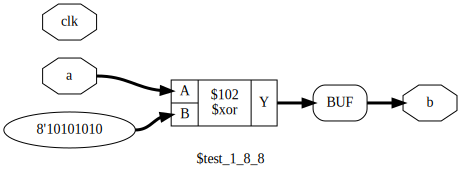

In [27]:
from myhdl.conversion import yshelper
from myhdl import *
import graphviz

@block
def test(clk, a, b):
    @always_comb
    def xor_assign():
        b.next = a ^ 0xaa

    return instances()

a, b = [ Signal(intbv()[8:]) for i in range(2) ]
clk = Signal(bool())

design = yshelper.Design("test")
inst = test(clk, a, b)
inst.convert("yosys_module", design, name="test", trace=True)

display(to_svg(design))


A bit of a more complex example:

In [24]:

@block
def up_counter(clk, ce, reset, counter):
    "Implements an UP counter - might overflow, depending on data type"
    @always_seq(clk.posedge, reset)
    def worker():
        if ce:
            counter.next = counter + 1
        else:
            counter.next = counter

    return instances()

@block
def simple_expr(clk, ce, reset, dout, debug):
    counter = Signal(modbv(0)[8:])
    d = Signal(intbv(3)[2:])

    ctr = up_counter(clk, ce, reset, counter)

    @always_comb
    def assign():
        if counter % 4 == 0:
            dout.next = 1 | 4 | 2
        else:
            dout.next = 0

    return instances()

clk = Signal(bool())
debug = Signal(bool(0))
ce = Signal(bool())
reset = ResetSignal(0, 1, isasync = False)
data_out = Signal(modbv()[8:])

design = design_from_entity(simple_expr)
design.display_rtl("", fmt="dot")

display(to_svg(design))



Error: bad label format {{<p21> CLK|<p22> D}|$worker::FunctionDef\\>:4\\counter\n$dff|{<p23> Q}}
Error: bad label format {{<p25> A|<p26> B|<p27> S}|$worker::FunctionDef\\>:4\\counter_rst\n$mux|{<p28> Y}}
Error: bad label format {{<p25> A|<p26> B|<p27> S}|$worker::Name\\>:6\\mux_counter\n$mux|{<p28> Y}}
Error: bad label format {{<p27> A|<p28> B|<p29> S}|$assign::Compare\\>:22\\mux_dout\n$mux|{<p30> Y}}


Setting context <myhdl.conversion.yshelper.Design object at 0x7f8e15505fd0>
insert key simple_expr_1_1_1_8_1
insert key up_counter_1_1_1_8
INFER INTERFACE for simple_expr
Analyze signals for < Instance simple_expr >
New Name clk <= clk (clk)
New Name debug <= debug (debug)
New Name ce <= ce (ce)
New Name reset <= reset (reset)
New local signal name data_out <= data_out (None)
WIRE a <--- a (a)
WIRE b <--- b (b)
New Name d <= d (d)
New Name counter <= counter (counter)
New Name dout <= dout (dout)
Analyze signals for < Instance up_counter_0_0_1_2_3_4_5_6 >
WIRE clk <--- clk (clk)
New local signal name debug <= debug (None)
WIRE ce <--- ce (ce)
WIRE reset <--- reset (reset)
WIRE data_out <--- data_out (None)
WIRE a <--- a (a)
WIRE b <--- b (b)
WIRE counter <--- counter (counter)
CREATE Module: 'simple_expr'
INFER INTERFACE for simple_expr
Adding module with name: simple_expr_1_1_1_8_1
TOP LEVEL SIGNALS
clk
ce
reset
dout
debug
---- DONE ----
# of block arguments: 5
ARG clk
	Wire IN clk, p

CalledProcessError: Command '['dot', '-Tsvg']' returned non-zero exit status 1. [stderr: b'Error: bad label format {{<p21> CLK|<p22> D}|$worker::FunctionDef\\\\>:4\\\\counter\\n$dff|{<p23> Q}}\nError: bad label format {{<p25> A|<p26> B|<p27> S}|$worker::FunctionDef\\\\>:4\\\\counter_rst\\n$mux|{<p28> Y}}\nError: bad label format {{<p25> A|<p26> B|<p27> S}|$worker::Name\\\\>:6\\\\mux_counter\\n$mux|{<p28> Y}}\nWarning: node c24, port p22 unrecognized\nWarning: node c29, port p27 unrecognized\nWarning: node c30, port p27 unrecognized\nWarning: node c24, port p21 unrecognized\nWarning: node c24, port p23 unrecognized\nWarning: node c29, port p26 unrecognized\nWarning: node c29, port p28 unrecognized\nWarning: node c30, port p28 unrecognized\nWarning: node c29, port p25 unrecognized\nWarning: node c30, port p26 unrecognized\nWarning: node c30, port p25 unrecognized\nError: bad label format {{<p27> A|<p28> B|<p29> S}|$assign::Compare\\\\>:22\\\\mux_dout\\n$mux|{<p30> Y}}\nWarning: node c31, port p30 unrecognized\nWarning: node c31, port p28 unrecognized\nWarning: node c31, port p29 unrecognized\nWarning: node c31, port p27 unrecognized\n']